# DQN на примере среды Gym Atari Pong

## Задание

1. Решить задачу Gym Atari с помощью DQN:
* Использовать только полносвязанные слои, оставив только один канал.
* Число эпизодов и других параметров обучения выбрать в соответствии с вычислительной мощностью.

2. Оптимизация параметров:
* Провести эксперименты с различными значениями параметров (коэффициент обесценивания gamma, скорость обучения alpha, ε для ε-жадной стратегии).
* Нарисовать графики зависимости "Среднего полного вознаграждения" от параметров gamma, alpha, epsilon
* Определить оптимальные значения параметров, которые приводят к наилучшим результатам в обучении.

## Установка и импорт библиотек и модулей

In [ ]:
!apt-get update
!apt-get install -y cmake libopenmpi-dev python3-opengl ffmpeg
!pip install torch torchvision opencv-python numpy
!pip install "gymnasium[atari]"
!pip install autorom[accept-rom-license]

In [ ]:
# Настройка среды Atari
import gymnasium as gym
import ale_py
gym.register_envs(ale_py)

# Библиотека для работы с нейронными сетями
import torch

# Модуль для создания нейронных сетей
import torch.nn as nn

# Модуль для оптимизации нейронных сетей
import torch.optim as optim

# Модуль с функциями активации и потерь
import torch.nn.functional as F

# Импорт трансформаций из torchvision для аугментации и предобработки изображений при работе с нейросетями
import torchvision.transforms as T

# Поддерживает обратное распространение
from torch.autograd import Variable

# Библиотека для работы с массивами
import numpy as np

# Структуры данных для буфера воспроизведения
from collections import deque, namedtuple

# Модуль для генерации случайных чисел
import random

# Модуль для работы с файловой системой
import os

# Модуль для кодирования и декодирования данных
import base64
from base64 import b64encode

# Импорт модуля time для работы со временем (например, задержки или измерения времени выполнения)
import time

# Импорт библиотеки PIL (Pillow) для открытия и обработки изображений в различных форматах
from PIL import Image

# Импорт OpenCV (cv2) — библиотеки для обработки изображений и компьютерного зрения
import cv2

# Модуль для работы с потоками данных
import io

# Библиотека для работы с изображениями и видео
import imageio

# Модуль для отображения HTML в Google Colab
from IPython.display import HTML

# Модуль для отображения видео в Google Colab
from IPython import display as ipythondisplay

# Модуль для записи видео
from gymnasium.wrappers import RecordVideo

# Библиотека для построения графиков
import matplotlib.pyplot as plt
%matplotlib inline

# Отключаем лишние предупреждения
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Устройство (GPU или CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:', device)

Device: cuda


## Исследование среды

In [ ]:
# Создание экземпляра среды Pong-v5
env = gym.envs.make("ALE/Pong-v5", render_mode='rgb_array')

In [ ]:
# Проверим кол-во состояний и действий
state_shape = env.observation_space.shape
n_action = env.action_space.n
print('The number of states (form):', state_shape)
print('The number of actions:', n_action)
print('Available actions:', env.unwrapped.get_action_meanings())

The number of states (form): (210, 160, 3)
The number of actions: 6
Available actions: ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


(np.float64(-0.5), np.float64(159.5), np.float64(209.5), np.float64(-0.5))

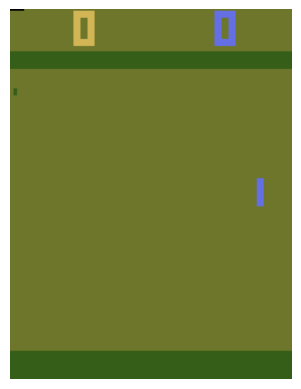

In [ ]:
# Отобразим среду на экране
env.reset()
prev_screen = env.render()
plt.imshow(prev_screen)
plt.axis('off')

В этой среде наблюдением является RGB-изображение на экране, который представляет собой матрицу. Форма матрицы (210, 160, 3), что соответствует изображению размера 210×160 с тремя RGB-каналами.

Агент (справа) может двигаться вверх и вниз и должен отбивать мяч. Если
он промахивается, то соперник (слева) получает 1 очко. Если же промахивается соперник, то 1 очко получает агент.

Выигрывает тот, кто первым наберет
21 очко. У агента имеется шесть возможных действий:
* 0: NOOP: агент стоит на месте;
* 1: FIRE: действие форсированного удара, агент остается на месте;
* 2: RIGHT: агент смещается вверх;
* 3: LEFT: агент смещается вниз;
* 4: RIGHTFIRE: форсированный удар и агент смещается вверх;
* 5: LEFTFIRE: форсированный удар и агент смещается вниз.


Каждое действие повторяется на протяжении k кадров (k может быть равно
2, 3, 4 или 16 в зависимости от варианта окружающей среды Pong).

Вознаграждение начисляется следующим образом:
* –1: агент промахнулся по мячу;
* 1: соперник промахнулся по мячу;
* 0: в остальных случаях.

Пространство наблюдений в игре Pong имеет размер 210 * 160 * 3. Предварительно уменьшим размер изображений до 84 * 84 с сохранением цветовой информации.

## Пошаговая реализация алгоритма DQN для среды Pong

### 1. Определим действия для среды

In [ ]:
ACTIONS = [0, 2, 3] # 'NOOP', 'RIGHT', 'LEFT'
n_action = len(ACTIONS)

Это следующие действия: оставаться на месте, сместиться вверх, сместиться вниз.

### 2. Выполним случайное действие

In [ ]:
# Сброс среды (environment) в начальное состояние перед началом эпизода
env.reset()

# Инициализация списка для хранения кадров (изображений) сцены (например, для сохранения видео)
frames = []

# Бесконечный цикл, в котором агент взаимодействует со средой
while True:
    # Случайный выбор действия из доступных действий
    action = ACTIONS[random.randint(0, n_action - 1)]

    # Выполнение действия в среде и получение нового наблюдения, награды и статуса завершения
    obs, reward, done, truncated, _ = env.step(action)

    # Рендеринг текущего состояния среды (визуализация текущего кадра)
    prev_screen = env.render()

    # Добавление текущего кадра в список frames для последующей обработки или сохранения
    frames.append(prev_screen)

    # Проверка условия завершения эпизода (done — цель достигнута, truncated — превышено время/шаги)
    if done or truncated:
        break

In [ ]:
path = './gym_animation.gif'
imageio.mimsave(path, frames, fps=30)

In [ ]:
def show_video(path):
    """
    Отображает GIF-файл в Google Colab
    @param path: путь к файлу
    """
    video = io.open(path, 'r+b').read()
    encoded = base64.b64encode(video)
    return HTML(data='''<img src="data:image/gif;base64,{0}" type="gif" />'''.format(encoded.decode('ascii')))


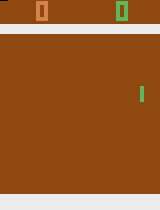

In [ ]:
show_video(path)

### 3. Определим функцию уменьшения размера изображения и его преобразования в полутона


In [ ]:
# Функция предобработки кадра
def preprocess_frame(frame):
    """
    Предобрабатывает входной кадр для уменьшения размерности и нормализации.
    @param frame (np.array): исходный RGB-кадр из среды Gym
    @param: np.array одномерный массив (вектор) с нормализованным градационным изображением (84x84 -> 7056)
    """
    # Преобразуем кадр из RGB в оттенки серого (GRAY)
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)

    # Изменяем размер кадра до 84x84 пикселей для упрощения обработки нейросетью
    frame = cv2.resize(frame, (84, 84))

    # Нормализуем значения пикселей — делим на 255, чтобы получить значения от 0 до 1
    frame = frame / 255.0

    # Преобразуем изображение в одномерный массив (вектор), подходящий для нейросети
    return frame.astype(np.float32).ravel()  # ravel() превращает матрицу в 1D-массив

### 4. Определим буфер воспроизведения опыта

In [ ]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))

In [ ]:
class ReplayBuffer:
    """
    Определение класса ReplayBuffer — реализация буфера воспроизведения (опытного хранилища), используемого в алгоритмах обучения с подкреплением для хранения переходов среды.
    """
    def __init__(self, capacity=10000):
        """
        Инициализация буфера на основе deque — двусторонней очереди.
        При превышении capacity самые старые элементы автоматически удаляются.
        @param capacity задаёт максимальное количество хранимых элементов.
        """
        self.buffer = deque(maxlen=capacity)

    def push(self, *args):
        """
        Метод для добавления нового перехода (состояние, действие, награда и т.д.) в буфер.
        Transition — это namedtuple, объединяющий компоненты одного шага (state, action, reward, next_state, done)
        """
        self.buffer.append(Transition(*args))

    def sample(self, batch_size):
        """
        Метод для случайной выборки из буфера batch_size переходов.
        random.sample — возвращает список уникальных элементов указанного размера,
        выбранных случайным образом без повторений.
        @param batch_size (int): размер батча
        """
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        """
        Возвращает текущее количество элементов в буфере.
        """
        return len(self.buffer)

### 5. Выполним реализацию класса DQN для алгоритма Double DQN

Используем только полносвязанные слои (MLP), оставив только один канал. Это значит, что нужно взять Linear (полносвязные), а также убедиться, что входной тензор соответствует требованиям модели.

In [ ]:
# Определение класса DQN — глубокой нейронной сети, используемой для оценки Q-значений действий.
# Наследуется от nn.Module — базового класса PyTorch для нейросетей.
class DQN(nn.Module):
    """
    Простая полносвязная нейронная сеть для использования в Deep Q-Network (DQN).
    Предназначена для оценки Q-значений для каждого возможного действия по текущему состоянию среды.
    """
    def __init__(self, input_dim, n_action):
        """
        Инициализация архитектуры нейросети.
        @param input_dim (int): размер входного вектора (количество признаков состояния)
        @param n_action (int): количество возможных действий (выходов сети)
        """
        super(DQN, self).__init__()

        # Определение последовательности слоёв сети:
        # Вход -> 256 нейронов + ReLU -> 128 нейронов + ReLU -> выход (n_action)
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),   # Первый полносвязный слой
            nn.ReLU(),                   # Функция активации
            nn.Linear(256, 128),         # Второй полносвязный слой
            nn.ReLU(),                   # Функция активации
            nn.Linear(128, n_action)    # Выходной слой: по одному выходу на каждое действие
        )

    def forward(self, x):
        """
        Прямой проход через сеть.
        @param x (torch.Tensor): тензор с входными данными (состояние среды)
        @return torch.Tensor: тензор с оценками Q-значений для каждого действия
        """
        return self.net(x)

### 6. Гиперпараметры

In [ ]:
# Размерность входного состояния
input_dim = 84 * 84

# Размер мини-батча
batch_size = 64

# Коэффициент дисконтирования будущих наград (чем ближе к 1, тем больше учитываются будущие награды)
gamma = 0.99

# Начальное значение epsilon для стратегии ε-greedy — вероятность выбора случайного действия
epsilon_start = 1.0

# Конечное значение epsilon — минимальная вероятность случайного действия (агент почти всегда выбирает лучшее действие)
epsilon_final = 0.01

# Множитель для уменьшения epsilon на каждом эпизоде (экспоненциальное затухание)
epsilon_decay = 0.99

# Скорость обучения (learning rate) для оптимизатора (например, Adam)
learning_rate = 0.005

# Частота обновления целевой сети (обновлять каждые target_update_freq шагов или эпизодов)
target_update_freq = 10

# Общее количество эпизодов обучения — сколько раз будет запущен полный цикл игры/среды
num_episodes = 1000

### 7. Инициализация моделей

In [ ]:
# Создание основной (policy) сети — она будет использоваться для выбора действий и обучаться на опыте
policy_net = DQN(input_dim, n_action).to(device)

# Создание целевой (target) сети — используется для стабилизации обучения,
# чтобы предотвратить колебания при вычислении целевых Q-значений
target_net = DQN(input_dim, n_action).to(device)

# Инициализация весов целевой сети теми же значениями, что и у policy-сети
target_net.load_state_dict(policy_net.state_dict())

# Перевод целевой сети в режим оценки (evaluation), так как мы не будем её обучать напрямую
target_net.eval()

# Оптимизатор Adam для обновления параметров policy-сети
optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)

# Инициализация буфера воспроизведения (Replay Buffer) для хранения переходов среды
# Нужен для обучения на случайных мини-батчах из прошлого опыта
memory = ReplayBuffer()

### 8. Определим ε-жадную стратегию

In [ ]:
def select_action(state, epsilon):
    """
    Выбирает действие из ограниченного списка ACTIONS с помощью ε-greedy стратегии.
    """
    if random.random() < epsilon:
        # Исследование: случайный выбор из доступных действий
        return random.randint(0, n_action - 1)
    else:
        # Эксплуатация: использование policy-сети для выбора лучшего действия
        with torch.no_grad():
            q_values = policy_net(state).cpu().squeeze()
            # Берём argmax только среди действий из ACTIONS
            return q_values.argmax().item()

### 9. Обучение

In [ ]:
def optimize_model():
    """
    Обучает policy_net (основную нейросеть) на случайной выборке из буфера воспроизведения.
    Используется Double DQN для улучшенной оценки целевых значений.
    """
    # Проверяем, достаточно ли данных в буфере для обучения
    if len(memory) < batch_size:
        return  # Выходим, если данных недостаточно

    # Делаем случайную выборку из буфера размером batch_size
    transitions = memory.sample(batch_size)

    # Преобразуем список переходов в отдельные списки для state, action, reward и т.д.
    # Transition — это namedtuple, объединяющий компоненты одного шага
    batch = Transition(*zip(*transitions))

    # Преобразуем батчи в тензоры PyTorch
    # Текущие состояния: объединяем все тензоры в один общий батч
    state_batch = torch.cat(batch.state)

    # Действия: преобразуем в тензор и добавляем измерение (unsqueeze)
    action_batch = torch.tensor(batch.action, device=device).unsqueeze(1)

    # Награды: преобразуем в тензор
    reward_batch = torch.tensor(batch.reward, device=device)

    # Флаг завершения эпизода (done): преобразуем в float32 для математических операций
    done_batch = torch.tensor(batch.done, device=device, dtype=torch.float32)

    # Следующие состояния: фильтруем и объединяем
    next_state_batch = torch.cat([s for s in batch.next_state])

    # Double DQN
    with torch.no_grad():  # Отключаем вычисление градиентов при подсчёте целевых значений
        # Определяем лучшие действия для следующих состояний с помощью policy_net
        next_actions = policy_net(next_state_batch).max(1)[1].unsqueeze(1)

        # Получаем Q-значения для этих действий с помощью target_net
        next_state_values = target_net(next_state_batch).gather(1, next_actions).squeeze()

    # Вычисляем ожидаемые Q-значения по формуле Беллмана:
    # Q(s,a) = r + γ * (1 - done) * max(Q'(s',a))
    expected_q_values = reward_batch + gamma * (1 - done_batch) * next_state_values

    # Получаем предсказанные Q-значения для выбранных действий из policy_net
    q_values = policy_net(state_batch).gather(1, action_batch).squeeze()

    # Вычисляем потери (ошибку) между предсказанными и ожидаемыми значениями
    loss = nn.MSELoss()(q_values, expected_q_values)

    # Обнуляем градиенты перед обратным распространением
    optimizer.zero_grad()

    # Выполняем backpropagation (расчёт градиентов)
    loss.backward()

    # Обновляем веса сети
    optimizer.step()

### 10. Тренировка

In [ ]:
# Список для хранения суммарных наград по каждому эпизоду
episode_rewards = []

# Основной цикл по эпизодам
for i_episode in range(num_episodes):
    # Сброс среды в начале каждого эпизода, получение начального состояния
    state = env.reset()[0]

    # Предобработка изображения
    state = preprocess_frame(state)

    # Преобразование состояния в тензор PyTorch и добавление размерности batch
    state = torch.tensor(state, device=device, dtype=torch.float32).unsqueeze(0)

    # Инициализация суммарной награды за эпизод
    total_reward = 0

    # Флаг завершения текущего эпизода
    done = False

    # Цикл внутри одного эпизода — пока среда не вернёт done == True
    while not done:
        # Уменьшение epsilon со временем (экспоненциальное затухание)
        # Но не ниже epsilon_final — чтобы сохранялось небольшое исследование
        epsilon = max(epsilon_final, epsilon_start * (epsilon_decay ** i_episode))

        # Выбор действия на основе текущего состояния и ε-greedy стратегии
        action_idx = select_action(state, epsilon)

        # Получаем реальное действие из списка ACTIONS
        action = ACTIONS[action_idx]

        # Выполняем действие в среде и получаем новый переход
        next_state, reward, terminated, truncated, info = env.step(action)

        # Проверяем, завершился ли эпизод (по причине окончания игры или лимита шагов)
        done = terminated or truncated

        # Предобрабатываем следующее состояние
        next_state = preprocess_frame(next_state)

        # Преобразуем в тензор и добавляем размерность batch
        next_state_tensor = torch.tensor(next_state, device=device, dtype=torch.float32).unsqueeze(0)

        # Добавляем полученную награду к общей сумме за эпизод
        total_reward += reward

        # Преобразуем reward и done в тензоры для сохранения в буфере
        reward_tensor = torch.tensor([reward], device=device)
        done_tensor = torch.tensor([done], device=device, dtype=torch.float32)

        # Сохраняем переход (state, action, next_state, reward, done) в буфер воспроизведения
        memory.push(state, action_idx, next_state_tensor, reward_tensor.item(), done_tensor.item())

        # Обновляем текущее состояние
        state = next_state_tensor

        # Обучаем модель на случайном мини-батче из буфера
        optimize_model()

    # Сохраняем общую награду за эпизод
    episode_rewards.append(total_reward)

    # Обновляем веса целевой сети (target_net) с определённой периодичностью
    if i_episode % target_update_freq == 0:
        target_net.load_state_dict(policy_net.state_dict())

    # Вывод информации о прогрессе обучения
    print(f"Episode {i_episode+1}, Total Reward: {total_reward:.2f}, Epsilon: {epsilon:.2f}")

# Закрытие среды после окончания всех эпизодов
env.close()

Episode 1, Total Reward: -21.00, Epsilon: 1.00
Episode 2, Total Reward: -21.00, Epsilon: 0.99
Episode 3, Total Reward: -19.00, Epsilon: 0.98
Episode 4, Total Reward: -20.00, Epsilon: 0.97
Episode 5, Total Reward: -19.00, Epsilon: 0.96
Episode 6, Total Reward: -18.00, Epsilon: 0.95
Episode 7, Total Reward: -21.00, Epsilon: 0.94
Episode 8, Total Reward: -20.00, Epsilon: 0.93
Episode 9, Total Reward: -20.00, Epsilon: 0.92
Episode 10, Total Reward: -21.00, Epsilon: 0.91
Episode 11, Total Reward: -21.00, Epsilon: 0.90
Episode 12, Total Reward: -21.00, Epsilon: 0.90
Episode 13, Total Reward: -19.00, Epsilon: 0.89
Episode 14, Total Reward: -21.00, Epsilon: 0.88
Episode 15, Total Reward: -21.00, Epsilon: 0.87
Episode 16, Total Reward: -19.00, Epsilon: 0.86
Episode 17, Total Reward: -19.00, Epsilon: 0.85
Episode 18, Total Reward: -21.00, Epsilon: 0.84
Episode 19, Total Reward: -21.00, Epsilon: 0.83
Episode 20, Total Reward: -21.00, Epsilon: 0.83
Episode 21, Total Reward: -21.00, Epsilon: 0.82
E

### 11. Построим график зависимости вознаграждения в эпизоде от времени

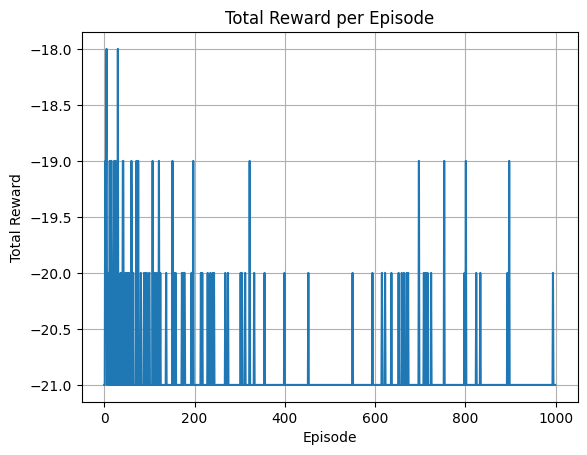

In [ ]:
# Построение графика суммарной награды за каждый эпизод
plt.plot(episode_rewards)

# Подпись оси X — номер эпизода
plt.xlabel('Episode')

# Подпись оси Y — общая награда, полученная в этом эпизоде
plt.ylabel('Total Reward')

# Заголовок графика
plt.title('Total Reward per Episode')

# Включение сетки для упрощения чтения графика
plt.grid(True)

# Отображение графика на экране
plt.show()

### 12. Отобразим графики зависимости "Среднего полного вознаграждения" от параметров gamma, alpha, epsilon

Функция тренировки:

In [ ]:
def train_dqn(gamma=0.99, learning_rate=1e-3, epsilon_start=1.0, num_episodes=100):
    """
    Функция для обучения агента в среде Pong с использованием алгоритма DQN.
    @param gamma (float): коэффициент дисконтирования будущих наград
    @param learning_rate (float): скорость обучения оптимизатора
    @param epsilon_start (float): начальное значение вероятности исследования
    @param num_episodes (int): количество эпизодов обучения
    @return avg_reward (float): средняя награда за эпизод
    """
    # Инициализация среды Gym 'Pong-v5' с режимом отрисовки 'rgb_array'
    env = gym.make("ALE/Pong-v5", render_mode='rgb_array')

    # Определение доступных действий (в Pong 0 - ничего, 2 - вверх, 3 - вниз)
    ACTIONS = [0, 2, 3]
    n_action = len(ACTIONS)  # Количество возможных действий

    # Размерность входного изображения после обработки: 84x84 пикселей
    input_dim = 84 * 84

    # Создание основной и целевой нейросети
    policy_net = DQN(input_dim, n_action).to(device)
    target_net = DQN(input_dim, n_action).to(device)

    # Загрузка весов policy_net в target_net на старте
    target_net.load_state_dict(policy_net.state_dict())

    # Переводим целевую сеть в режим оценки (без обновления градиентов)
    target_net.eval()

    # Оптимизатор Adam для обновления весов policy_net
    optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)

    # Буфер воспроизведения для хранения переходов (state, action, next_state, reward, done)
    memory = ReplayBuffer()

    # Дополнительные гиперпараметры
    epsilon_final = 0.01          # Минимальное значение epsilon
    epsilon_decay = 0.995         # Коэффициент уменьшения epsilon
    target_update_freq = 10       # Частота обновления целевой сети

    # Список для хранения суммарных наград по каждому эпизоду
    episode_rewards = []

    # Цикл по эпизодам обучения
    for i_episode in range(num_episodes):
        # Сброс среды и получение начального состояния
        state = env.reset()[0]

        # Предобработка текущего кадра (например, grayscale, resize, нормализация)
        state = preprocess_frame(state)

        # Преобразование в тензор PyTorch и добавление batch-размерности
        state = torch.tensor(state, device=device, dtype=torch.float32).unsqueeze(0)

        # Общая награда за эпизод
        total_reward = 0

        # Флаг завершения эпизода
        done = False

        # Цикл внутри одного эпизода — пока не будет done == True
        while not done:
            # Уменьшение epsilon со временем (экспоненциальное затухание)
            epsilon = max(epsilon_final, epsilon_start * (epsilon_decay ** i_episode))

            # Выбор действия через ε-greedy стратегию
            action_idx = select_action(state, epsilon)
            action = ACTIONS[action_idx] # Получаем реальное действие из списка

            # Выполняем действие в среде и получаем новый переход
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated # Проверяем завершение эпизода

            # Предобработка следующего состояния
            next_state = preprocess_frame(next_state)

            # Преобразуем в тензор и добавляем размерность batch
            next_state_tensor = torch.tensor(next_state, device=device, dtype=torch.float32).unsqueeze(0)

            # Добавляем полученную награду к общей сумме
            total_reward += reward

            # Сохраняем переход в буфер воспроизведения
            memory.push(state, action_idx, next_state_tensor, reward, done)

            # Переход к следующему состоянию
            state = next_state_tensor

            # Обучение модели на случайном мини-батче из буфера
            optimize_model(policy_net, target_net, memory, optimizer, batch_size=64, gamma=gamma, n_action=n_action)

        # Сохраняем общую награду за эпизод
        episode_rewards.append(total_reward)

        # Обновляем веса целевой сети с заданной периодичностью
        if i_episode % target_update_freq == 0:
            target_net.load_state_dict(policy_net.state_dict())

    # Закрываем среду после окончания всех эпизодов
    env.close()

    # Вычисляем среднюю награду по всем эпизодам
    avg_reward = np.mean(episode_rewards)

    return avg_reward

Вспомогательные функции:

In [ ]:
def optimize_model(policy_net, target_net, memory, optimizer, batch_size, gamma, n_action):
    """
    Обучает policy-сеть на случайной выборке из буфера воспроизведения.
    Используется Double DQN для более стабильной оценки целевых Q-значений.
    @param policy_net (nn.Module): основная сеть, которую обучают
    @param target_net (nn.Module): целевая сеть для стабилизации обучения
    @param memory (ReplayBuffer): буфер воспроизведения с переходами среды
    @param optimizer (torch.optim): оптимизатор для обновления весов сети
    @param batch_size (int): размер мини-батча
    @param gamma (float): коэффициент дисконтирования будущих наград
    @param n_action (int): количество возможных действий
    """
    # Проверяем, достаточно ли данных в буфере для выборки
    if len(memory) < batch_size:
        return  # Если недостаточно — выходим без обучения

    # Выбираем случайный батч переходов из буфера
    transitions = memory.sample(batch_size)

    # Преобразуем список переходов в отдельные списки (state, action, reward и т.д.)
    # Transition — это namedtuple, объединяющий компоненты одного шага
    batch = Transition(*zip(*transitions))

    # Формируем батчи тензоров для обучения
    # Текущие состояния: объединяем все тензоры в один общий батч
    state_batch = torch.cat(batch.state)

    # Действия: преобразуем в тензор и добавляем измерение (unsqueeze) для gather
    action_batch = torch.tensor(batch.action, device=device).unsqueeze(1)

    # Награды: преобразуем в тензор
    reward_batch = torch.tensor(batch.reward, device=device)

    # Флаг завершения эпизода (done): преобразуем в float32 для математических операций
    done_batch = torch.tensor(batch.done, device=device, dtype=torch.float32)

    # Следующие состояния: фильтруем и объединяем
    next_state_batch = torch.cat([s for s in batch.next_state])

    # Double DQN
    with torch.no_grad():  # Отключаем вычисление градиентов при подсчёте целевых значений
        # Определяем лучшие действия для следующих состояний с помощью policy_net
        next_actions = policy_net(next_state_batch).max(1)[1].unsqueeze(1)

        # Получаем Q-значения для этих действий с помощью target_net
        next_state_values = target_net(next_state_batch).gather(1, next_actions).squeeze()

    # Вычисляем ожидаемые Q-значения по формуле Bellman:
    # Q(s,a) = r + γ * (1 - done) * max(Q'(s',a))
    expected_q_values = reward_batch + (1 - done_batch) * gamma * next_state_values

    # Получаем предсказанные Q-значения для выбранных действий из policy_net
    q_values = policy_net(state_batch).gather(1, action_batch).squeeze()

    # Вычисляем потери (ошибку) между предсказанными и ожидаемыми значениями
    loss = nn.MSELoss()(q_values, expected_q_values)

    # Обнуляем градиенты перед обратным распространением
    optimizer.zero_grad()

    # Выполняем backpropagation (расчёт градиентов)
    loss.backward()

    # Обновляем веса сети
    optimizer.step()

Функция для построения графиков:

In [ ]:
def run_experiments_and_plot(num_e=50):
    """
    Проводит серию экспериментов с разными значениями гиперпараметров (gamma, learning rate, epsilon),
    обучает агента в среде Pong и строит графики зависимости средней награды от каждого параметра.
    @param num_e (int): кол-во эпизодов для каждого гиперпараметра
    """
    # Определяем наборы значений для тестирования:
    gammas = [0.9, 0.95, 0.99]       # Разные коэффициенты дисконтирования
    alphas = [5e-3, 1e-3, 1e-4]      # Разные скорости обучения (learning rate)
    epsilons = [1.0, 0.5, 0.1]       # Разные начальные значения epsilon

    # Списки для хранения результатов
    results_gamma = []
    results_alpha = []
    results_epsilon = []

    # Тестирование влияния gamma (коэффициент дисконтирования будущих наград)
    print("Testing gamma...")
    for g in gammas:
        print(f"gamma = {g}")
        avg_r = train_dqn(gamma=g, num_episodes=num_e)  # Обучаем агента с фиксированным gamma
        results_gamma.append((g, avg_r))  # Сохраняем пару (значение гиперпараметра, средняя награда)

    # Тестирование влияния learning_rate (скорость обучения)
    print("Testing alpha...")
    for a in alphas:
        print(f"alpha = {a}")
        avg_r = train_dqn(learning_rate=a, num_episodes=num_e)  # Меняем learning_rate
        results_alpha.append((a, avg_r))

    # Тестирование влияния начального epsilon (степень исследования)
    print("Testing epsilon...")
    for e in epsilons:
        print(f"epsilon = {e}")
        avg_r = train_dqn(epsilon_start=e, num_episodes=num_e)  # Меняем начальное значение epsilon
        results_epsilon.append((e, avg_r))

    # Разделяем значения гиперпараметров и соответствующие им средние награды
    x_g, y_g = zip(*results_gamma)
    x_a, y_a = zip(*results_alpha)
    x_e, y_e = zip(*results_epsilon)

    # Создаём общую фигуру для трёх графиков
    plt.figure(figsize=(15, 5))

    # График 1: Зависимость средней награды от gamma
    plt.subplot(1, 3, 1)
    plt.plot(x_g, y_g, 'o-') # 'o-' рисует точки и линии между ними
    plt.title("Average reward vs Gamma")
    plt.xlabel("Gamma") # Коэффициент дисконтирования
    plt.ylabel("Average reward") # Средняя награда за эпизод

    # График 2: Зависимость средней награды от learning rate
    plt.subplot(1, 3, 2)
    plt.plot(x_a, y_a, 'o-')
    plt.title("Average reward vs Learning Rate (Alpha)")
    plt.xlabel("Learning Rate (Alpha)") # Скорость обучения
    plt.ylabel("Average reward")

    # График 3: Зависимость средней награды от начального epsilon
    plt.subplot(1, 3, 3)
    plt.plot(x_e, y_e, 'o-')
    plt.title("Average reward vs Epsilon")
    plt.xlabel("Epsilon") # Начальная вероятность случайного действия
    plt.ylabel("Average reward")

    # Улучшаем расположение графиков
    plt.tight_layout()

    # Отображаем все графики
    plt.show()

Testing gamma...
gamma = 0.9
gamma = 0.95
gamma = 0.99
Testing alpha...
alpha = 0.005
alpha = 0.001
alpha = 0.0001
Testing epsilon...
epsilon = 1.0
epsilon = 0.5
epsilon = 0.1


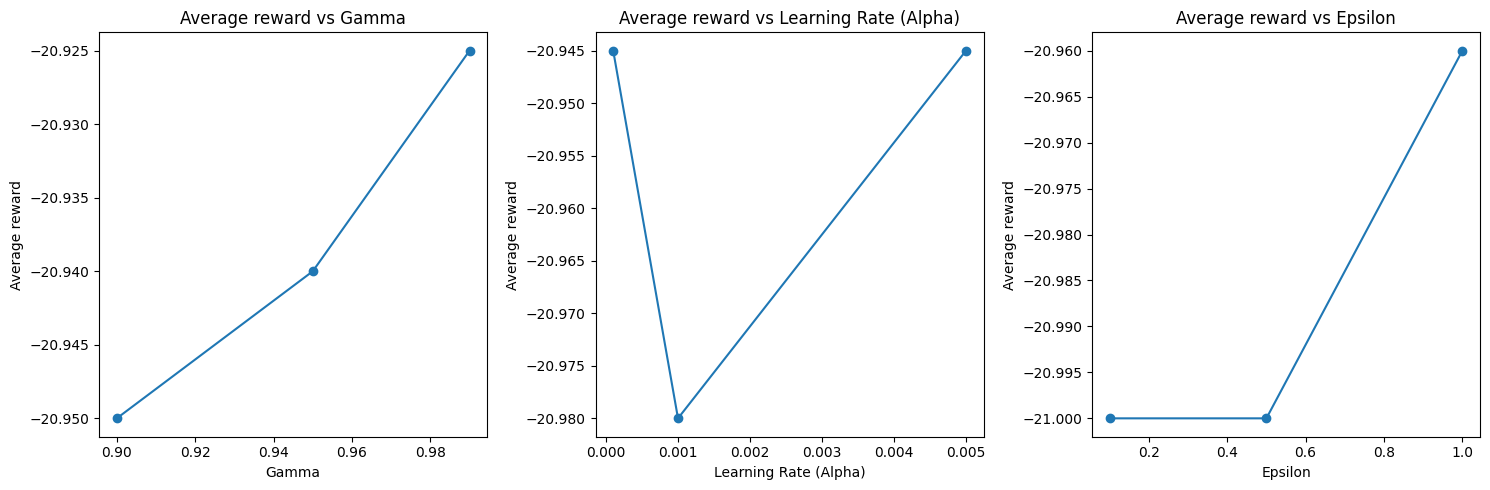

In [ ]:
# Запуск экспериментов:
run_experiments_and_plot(num_e=200)